## Data

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from hopfield import NonidentityRecon, DiscreteTimeHopfieldLayer, sign, softly
from mnist import load_mnist

%matplotlib inline

tf.random.set_seed(42)
tf.keras.backend.clear_session()
print(tf.__version__)

2.3.0


In [2]:
# IMAGE_SIZE = (32, 32)  # XXX: test!
IMAGE_SIZE = (8, 8)
BINARIZE = True

In [3]:
(x_train, _), _ = load_mnist(image_size=IMAGE_SIZE, binarize=BINARIZE)

## Model

In [4]:
class RBMRecon(NonidentityRecon):
    """Restricted Boltzmann machine (RBM) based non-identity re-constructor.

    RBM -- LDPC -- AE

    Notes
    -----
    Non-identity: The latent dimension `latent_dim` shall be smaller the
        ambient dimension, for ensuring the non-identity of the re-constructor.

    References
    ----------
    * Introduction to low-density parity-check (LDPC) code:
        1. https://medium.com/5g-nr/ldpc-low-density-parity-check-code-8a4444153934
    * Introduction to Boltzmann machine:
        2. https://medium.com/edureka/restricted-boltzmann-machine-tutorial-991ae688c154
    * Relation between Boltzmann machine and auto-encoder:
        3. https://www.cs.cmu.edu/~rsalakhu/talk_Simons_part2_pdf.pdf

    Parameters
    ----------
    activation : callable
    latent_dim : int
    binarize : callable, optional
    """

    def __init__(self,
                 activation,
                 latent_dim,
                 binarize=None,
                 **kwargs):
        super().__init__(**kwargs)
        self.activation = activation
        self.latent_dim = latent_dim
        if binarize is None:
            self.softly_binarize = None
        else:
            self.softly_binarize = softly(binarize)

    def build(self, input_shape):
        depth = input_shape[-1]
        assert depth > self.latent_dim

        self.kernel = self.add_weight(
            name='kernel',
            shape=[depth, self.latent_dim],
            initializer='glorot_uniform',
            trainable=True)
        self.latent_bias = self.add_weight(
            name='latent_bias',
            shape=[self.latent_dim],
            initializer='zeros',
            trainable=True)
        self.ambient_bias = self.add_weight(
            name='ambient_bias',
            shape=[depth],
            initializer='zeros',
            trainable=True)
        super().build(input_shape)

    def call(self, x):
        W, b, v = self.kernel, self.latent_bias, self.ambient_bias
        z = x @ W + b
        if self.activation is not None:
            z = self.activation(z)
        if self.softly_binarize is not None:
            z = self.softly_binarize(z)
        y = z @ tf.transpose(W) + v
        if self.activation is not None:
            y = self.activation(y)
        if self.softly_binarize is not None:
            y = self.softly_binarize(y)
        return y

In [5]:
def create_model(num_repeat, latent_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.RepeatVector(num_repeat),
        tf.keras.layers.Reshape([-1]),
        DiscreteTimeHopfieldLayer(
            RBMRecon(
                activation=tf.tanh,
                latent_dim=latent_dim,
                binarize=sign,
            ),
            max_steps=20,
            reg_factor=1),
        tf.keras.layers.Reshape([num_repeat, -1]),
        tf.keras.layers.Lambda(
            lambda x: softly(sign)(tf.reduce_mean(x, axis=-2))),
    ])
    model.compile(optimizer='adam')
    return model

In [6]:
X = x_train[:200].numpy()

ds0 = tf.data.Dataset.from_tensor_slices(X)
ds = ds0.shuffle(10000).repeat(10000).batch(128)
model = create_model(num_repeat=16, latent_dim=256)
model.fit(ds)

15625/15625 [==============================] - 152s 10ms/step - loss: 7.1229e-04


In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
repeat_vector (RepeatVector) (None, 16, 64)            0         
_________________________________________________________________
reshape (Reshape)            (None, 1024)              0         
_________________________________________________________________
discrete_time_hopfield_layer (None, 1024)              263425    
_________________________________________________________________
reshape_1 (Reshape)          (None, 16, 64)            0         
_________________________________________________________________
lambda (Lambda)              (None, 64)                0         
Total params: 263,425
Trainable params: 263,424
Non-trainable params: 1
_________________________________________________________________


In [8]:
# noised_X = X + np.random.normal(size=X.shape) * 0.3
noised_X = np.where(np.random.random(size=X.shape) < 0.125, -X, X)
recon_X = model.predict(noised_X)

for layer in model.layers:
    try:
        print('Relax steps:', layer.final_step.numpy())
    except AttributeError:
        pass

orig_err = noised_X - X
err = recon_X - X
print(f'{np.quantile(np.abs(orig_err), 0.95)} => '
      f'{np.quantile(np.abs(err), 0.95)}')

Relax steps: 8
2.0 => 0.0


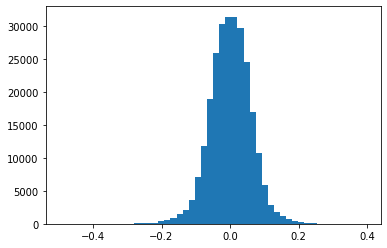

In [9]:
original_W = model.layers[2].non_identity_recon.kernel.numpy()

# plot W's histogram
plt.hist(original_W.reshape([-1]), bins=50)
plt.show()

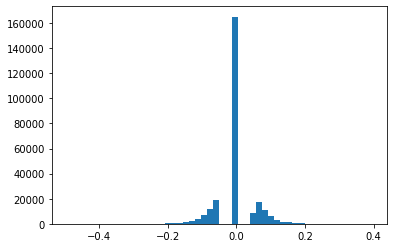

In [10]:
# clip the small value elements of the W
clipped_W = np.where(np.abs(original_W) < 0.05, 0., original_W)
model.layers[2].non_identity_recon.kernel.assign(
    tf.constant(clipped_W, dtype='float32'))

# plot W's histogram, after clipping
plt.hist(clipped_W.reshape([-1]), bins=50)
plt.show()

In [11]:
# use the clipped model to test the de-noising effect

recon_X = model.predict(noised_X)

for layer in model.layers:
    try:
        print('Relax steps:', layer.final_step.numpy())
    except AttributeError:
        pass

orig_err = noised_X - X
err = recon_X - X
print(f'{np.quantile(np.abs(orig_err), 0.95)} => '
      f'{np.quantile(np.abs(err), 0.95)}')

Relax steps: 6
2.0 => 0.0


## Conclusions

1. RBM based (soft) binary re-constructor also provides the de-noising property for the discrete-time Hopfield network. Also, it solves the problem of the traditional dense re-constructor, the case where the input dimension is too small so that the perceptron cannot get enough capacity for learning sufficient many patterns. (Recall that simply duplicating the pattern will break the non-identity down for the traditional dense re-constructor. But it's fine in case of the RBM based re-constructor.)
1. However, comparing with the traditional dense re-constructor, the de-noising effect, even though still persists, reduces. 